In [1]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.4 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel
import torch
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/My Drive/w266_project')
df = pd.read_csv("features.csv", header = 0, sep="\t", index_col=0)

In [5]:
# Load SciBERT tokenizer and model
model_checkpoint = "allenai/scibert_scivocab_uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [6]:
X = df[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words', 'Funding','Auth_country', 'Pub_country', 'Abstract']]
y = df['JIF']

train_idx, val_idx, y_train, y_val = train_test_split(range(len(df)), y, test_size=0.3, random_state=42)

In [7]:
class JIF_ranker:
    def __init__(self):
        self.LUT = pd.DataFrame()


    def fit(self, series: pd.Series):
        self.LUT = pd.DataFrame(series.groupby(series).size().cumsum()/len(series))
        self.LUT.columns = ['Rank']
        self.LUT.reset_index(inplace = True)
        self.LUT.columns = ['JIF', 'Rank']


    def rank_to_JIF(self, rank:float):
        if (rank <= 1) & (rank >= 0):
            idx = (self.LUT['Rank']- rank).abs().argsort()[:2].sort_values()
            JIF_before = self.LUT.iloc[idx]['JIF'].iloc[0]
            JIF_after = self.LUT.iloc[idx]['JIF'].iloc[1]
            rank_before = self.LUT.iloc[idx]['Rank'].iloc[0]
            rank_after = self.LUT.iloc[idx]['Rank'].iloc[1]
            JIF_to_return = JIF_before + (JIF_after-JIF_before)*(rank-rank_before)/(rank_after-rank_before)
        else:
            JIF_to_return = False
        return JIF_to_return

    def JIF_to_rank(self, JIF:float):
        idx = (self.LUT['JIF']- JIF).abs().argsort()[:2].sort_values()
        JIF_before = self.LUT.iloc[idx]['JIF'].iloc[0]
        JIF_after = self.LUT.iloc[idx]['JIF'].iloc[1]
        rank_before = self.LUT.iloc[idx]['Rank'].iloc[0]
        rank_after = self.LUT.iloc[idx]['Rank'].iloc[1]
        rank_to_return = rank_before + (rank_after-rank_before)*(JIF-JIF_before)/(JIF_after-JIF_before)
        return rank_to_return

In [8]:
ranker = JIF_ranker()
ranker.fit(y_train)
y_train_rank = np.array(y_train.apply(lambda x: ranker.JIF_to_rank(x)))
y_val_rank = np.array(y_val.apply(lambda x: ranker.JIF_to_rank(x)))

In [9]:
# Prepare categorical data
categories = ['Funding','Auth_country', 'Pub_country']
train_one_hot_data = {}
val_one_hot_data = {}
for cat in categories:
  one_hot_df = pd.get_dummies(df[cat], prefix=cat, dtype=int)
  train_one_hot_data[cat] = one_hot_df.iloc[train_idx]
  val_one_hot_data[cat] = one_hot_df.iloc[val_idx]

# Prepare numerical data
num_data = X[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words']]
scaler  = MinMaxScaler(feature_range=(0,1))
num_data = scaler.fit_transform(num_data)
train_num_data = num_data[train_idx]
val_num_data = num_data[val_idx]

In [10]:
max_length = 400
train_encodings = bert_tokenizer(list(X['Abstract'].iloc[train_idx]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_encodings = bert_tokenizer(list(X['Abstract'].iloc[val_idx]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

### Sigmoid activation


In [11]:
hidden_size = 768 + 5 + 49 + 10 + 1
dropout = 0.3
learning_rate = 0.000005
bert_model.trainable = False

num_of_levels  = df['Funding'].nunique()
#Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Funding embeding size: {embedding_size}')

fund_input = keras.layers.Input(shape=(num_of_levels,), name = 'fund_input')
fund_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'fund_emb')(fund_input)
fund_emb= tf.keras.layers.Dropout(dropout)(fund_emb)
fund_flat = keras.layers.Flatten(name = 'fund_flat')(fund_emb)

num_of_levels  = df['Auth_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Auth cont embeding size: {embedding_size}')

Auth_input = keras.layers.Input(shape=(num_of_levels,), name = 'Auth_input')
Auth_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Auth_emb')(Auth_input)
Auth_emb= tf.keras.layers.Dropout(dropout)(Auth_emb)
Auth_flat = keras.layers.Flatten(name = 'Auth_flat')(Auth_emb)

num_of_levels  = df['Pub_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Pub cont embeding size: {embedding_size}')

Pub_input = keras.layers.Input(shape=(num_of_levels,), name = 'Pub_input')
Pub_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Pub_emb')(Pub_input)
Pub_emb = tf.keras.layers.Dropout(dropout)(Pub_emb)
Pub_flat = keras.layers.Flatten(name = 'Pub_flat')(Pub_emb)

inp_num_data = keras.layers.Input(shape=(num_data.shape[1],), name = 'Num feat')

input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

bert_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}

bert_out = bert_model(bert_inputs)

token = bert_out[0][:, 0, :] #cls token

# Concatenate all layers
conc = keras.layers.Concatenate()([inp_num_data, token])

hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(conc)
hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)


# Create output layer
out = keras.layers.Dense(1, activation=keras.activations.sigmoid, name = 'Regression_layer')(hidden1)
model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask,
                            fund_input, Auth_input, Pub_input,
                            inp_num_data], outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])

Funding embeding size: 1
Auth cont embeding size: 47
Pub cont embeding size: 10


In [12]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

history_sigmoid = model.fit([ train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask,
           train_one_hot_data['Funding'], train_one_hot_data['Auth_country'], train_one_hot_data['Pub_country'],
           train_num_data],
           y_train_rank,
           validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                            val_one_hot_data['Funding'], val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'],
                            val_num_data],
                            y_val_rank),
           batch_size=32, epochs=60, callbacks=[early_stopping])

Epoch 1/60
100/100 [==============================] - 67s 507ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0727 - val_mean_squared_error: 0.0727
Epoch 2/60
100/100 [==============================] - 47s 468ms/step - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 0.0698 - val_mean_squared_error: 0.0698
Epoch 3/60
100/100 [==============================] - 48s 480ms/step - loss: 0.0799 - mean_squared_error: 0.0799 - val_loss: 0.0665 - val_mean_squared_error: 0.0665
Epoch 4/60
100/100 [==============================] - 46s 466ms/step - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.0656 - val_mean_squared_error: 0.0656
Epoch 5/60
100/100 [==============================] - 55s 549ms/step - loss: 0.0732 - mean_squared_error: 0.0732 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 6/60
100/100 [==============================] - 47s 470ms/step - loss: 0.0735 - mean_squared_error: 0.0735 - val_loss: 0.0626 - val_mean_squared_error: 0.0626
Epoch 7/60

In [13]:
pred = model.predict([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                      val_one_hot_data['Funding'], val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'],
                      val_num_data])

43/43 [==============================] - 16s 295ms/step


In [ ]:
predictions = pred.reshape((-1))
fig, ax = plt.subplots()
ax.hist2d(predictions, y_val_rank , bins=(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01)))
ax.set_title('BERT with metadata')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [15]:
np.corrcoef(predictions, y_val_rank)

array([[1.        , 0.61285077],
       [0.61285077, 1.        ]])

In [16]:
df_to_save = pd.DataFrame({'Observed':y_val_rank, 'Predicted':predictions})
df_to_save.to_csv('scibert_meta_rank.csv', '\t')

In [17]:
pred_JIF = [ranker.rank_to_JIF(x) for x in predictions]
np.corrcoef(pred_JIF, y_val)

array([[1.        , 0.58727437],
       [0.58727437, 1.        ]])

(0.0, 14.0)

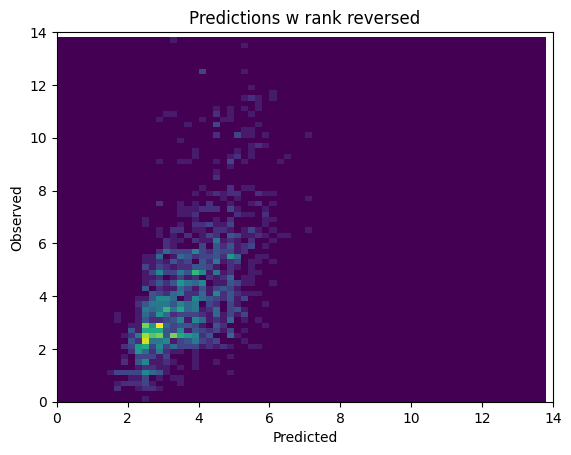

In [18]:
fig, ax = plt.subplots()
ax.hist2d(pred_JIF, y_val, bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('Predictions w rank reversed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_ylim(0,14)
ax.set_xlim(0,14)

In [19]:
df_to_save = pd.DataFrame({'Observed':y_val, 'Predicted':pred_JIF})
df_to_save.to_csv('scibert_meta_ranktoJIF.csv', '\t')

### Linear activation

In [20]:
hidden_size = 768 + 5 + 49 + 10 + 1
dropout = 0.3
learning_rate = 0.000005
bert_model.trainable = False

num_of_levels  = df['Funding'].nunique()
#Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Funding embeding size: {embedding_size}')

fund_input = keras.layers.Input(shape=(num_of_levels,), name = 'fund_input')
fund_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'fund_emb')(fund_input)
fund_flat = keras.layers.Flatten(name = 'fund_flat')(fund_emb)

num_of_levels  = df['Auth_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Auth cont embeding size: {embedding_size}')

Auth_input = keras.layers.Input(shape=(num_of_levels,), name = 'Auth_input')
Auth_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Auth_emb')(Auth_input)
Auth_flat = keras.layers.Flatten(name = 'Auth_flat')(Auth_emb)

num_of_levels  = df['Pub_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Pub cont embeding size: {embedding_size}')

Pub_input = keras.layers.Input(shape=(num_of_levels,), name = 'Pub_input')
Pub_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Pub_emb')(Pub_input)
Pub_flat = keras.layers.Flatten(name = 'Pub_flat')(Pub_emb)

inp_num_data = keras.layers.Input(shape=(num_data.shape[1],), name = 'Num feat')

input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

bert_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}

bert_out = bert_model(bert_inputs)

token = bert_out[0][:, 0, :] #cls token

# Concatenate all layers
conc = keras.layers.Concatenate()([inp_num_data, token])

hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(conc)
hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

hidden2 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden1)
hidden2 = tf.keras.layers.Dropout(dropout)(hidden2)


# Create output layer
out = keras.layers.Dense(1, activation='linear', name = 'Regression_layer')(hidden2)
model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask,
                            fund_input, Auth_input, Pub_input,
                            inp_num_data], outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])

Funding embeding size: 1
Auth cont embeding size: 47
Pub cont embeding size: 10


In [21]:
history_linear = model.fit([ train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask,
           train_one_hot_data['Funding'], train_one_hot_data['Auth_country'], train_one_hot_data['Pub_country'],
           train_num_data],
           y_train_rank,
           validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                            val_one_hot_data['Funding'], val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'],
                            val_num_data],
                            y_val_rank),
           batch_size=16, epochs=40, callbacks=[early_stopping])

Epoch 1/40
102/199 [==============>...............] - ETA: 18s - loss: 0.3786 - mean_squared_error: 0.3786

KeyboardInterrupt: 

In [ ]:
pred = model.predict([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                      val_one_hot_data['Funding'], val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'],
                      val_num_data])

predictions = pred.reshape((-1))
fig, ax = plt.subplots()
ax.hist2d(predictions, y_val_rank , bins=(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01)))
ax.set_title('Rank prediction w linear activation')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_ylim(0,1)
ax.set_xlim(0,1)

In [ ]:
pred_JIF = [ranker.rank_to_JIF(x) for x in predictions]
np.corrcoef(pred_JIF, y_val)